# Download Dataset

In [ ]:
import kaggle
import os

# Define your preferred download path
preferred_path = "/scratch/gohil.de/GenAI_Med/Project/data"

# Ensure the directory exists
os.makedirs(preferred_path, exist_ok=True)

# Download and unzip the dataset
kaggle.api.dataset_download_files(
    'raddar/chest-xrays-indiana-university',
    path=preferred_path,
    unzip=True
)

print("Dataset downloaded and extracted to:", preferred_path)

# Merge Filename and Report

In [5]:
import pandas as pd

# Load both CSV files
projections_df = pd.read_csv('data/indiana_projections.csv')
reports_df = pd.read_csv('data/indiana_reports.csv')

# Display basic information about each dataframe
print(f"Projections shape: {projections_df.shape}")
print(f"Reports shape: {reports_df.shape}")

# Check for duplicate UIDs in each dataframe
print(f"Unique UIDs in projections: {projections_df['uid'].nunique()}")
print(f"Unique UIDs in reports: {reports_df['uid'].nunique()}")

# Merge the dataframes on the 'uid' column
# Using left join to keep all rows from projections
merged_df = pd.merge(
    left=projections_df,
    right=reports_df,
    on='uid',
    how='left'
)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('data/indiana_dataset.csv', index=False)
print("\nMerged data saved to 'data/indiana_dataset.csv'")

Projections shape: (7466, 3)
Reports shape: (3851, 8)
Unique UIDs in projections: 3851
Unique UIDs in reports: 3851

Merged data saved to 'data/indiana_dataset.csv'


In [7]:
import pandas as pd

df = pd.read_csv("data/indiana_dataset.csv")
df.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."


In [10]:
df.columns

Index(['uid', 'filename', 'projection', 'MeSH', 'Problems', 'image',
       'indication', 'comparison', 'findings', 'impression'],
      dtype='object')

# Change file name to relative path and format report

In [11]:
import pandas as pd

# Create a new dataframe with the requested columns
labeled_df = pd.DataFrame()

# Copy the uid column
labeled_df['uid'] = df['uid']

# Create the filename column with the path prefix
labeled_df['filename'] = 'data/images/images_normalized/' + df['filename']

# Create the label column with the specified format
labeled_df['label'] = df.apply(
    lambda row: f"{row['projection']} chest X-ray showing {row['impression']}", 
    axis=1
)

# Save the new dataframe to a CSV file
output_file = 'indiana_labeled_data.csv'
labeled_df.to_csv(output_file, index=False)
print(f"\nLabeled data saved to '{output_file}'")
print(f"The labeled file contains {labeled_df.shape[0]} rows and {labeled_df.shape[1]} columns")


Labeled data saved to 'indiana_labeled_data.csv'
The labeled file contains 7466 rows and 3 columns


In [12]:
# Display the first few rows
labeled_df.head()

,uid,filename,label
0,1,data/images/images_normalized/1_IM-0001-4001.d...,Frontal chest X-ray showing Normal chest x-XXXX.
1,1,data/images/images_normalized/1_IM-0001-3001.d...,Lateral chest X-ray showing Normal chest x-XXXX.
2,2,data/images/images_normalized/2_IM-0652-1001.d...,Frontal chest X-ray showing No acute pulmonary...
3,2,data/images/images_normalized/2_IM-0652-2001.d...,Lateral chest X-ray showing No acute pulmonary...
4,3,data/images/images_normalized/3_IM-1384-1001.d...,Frontal chest X-ray showing No displaced rib f...


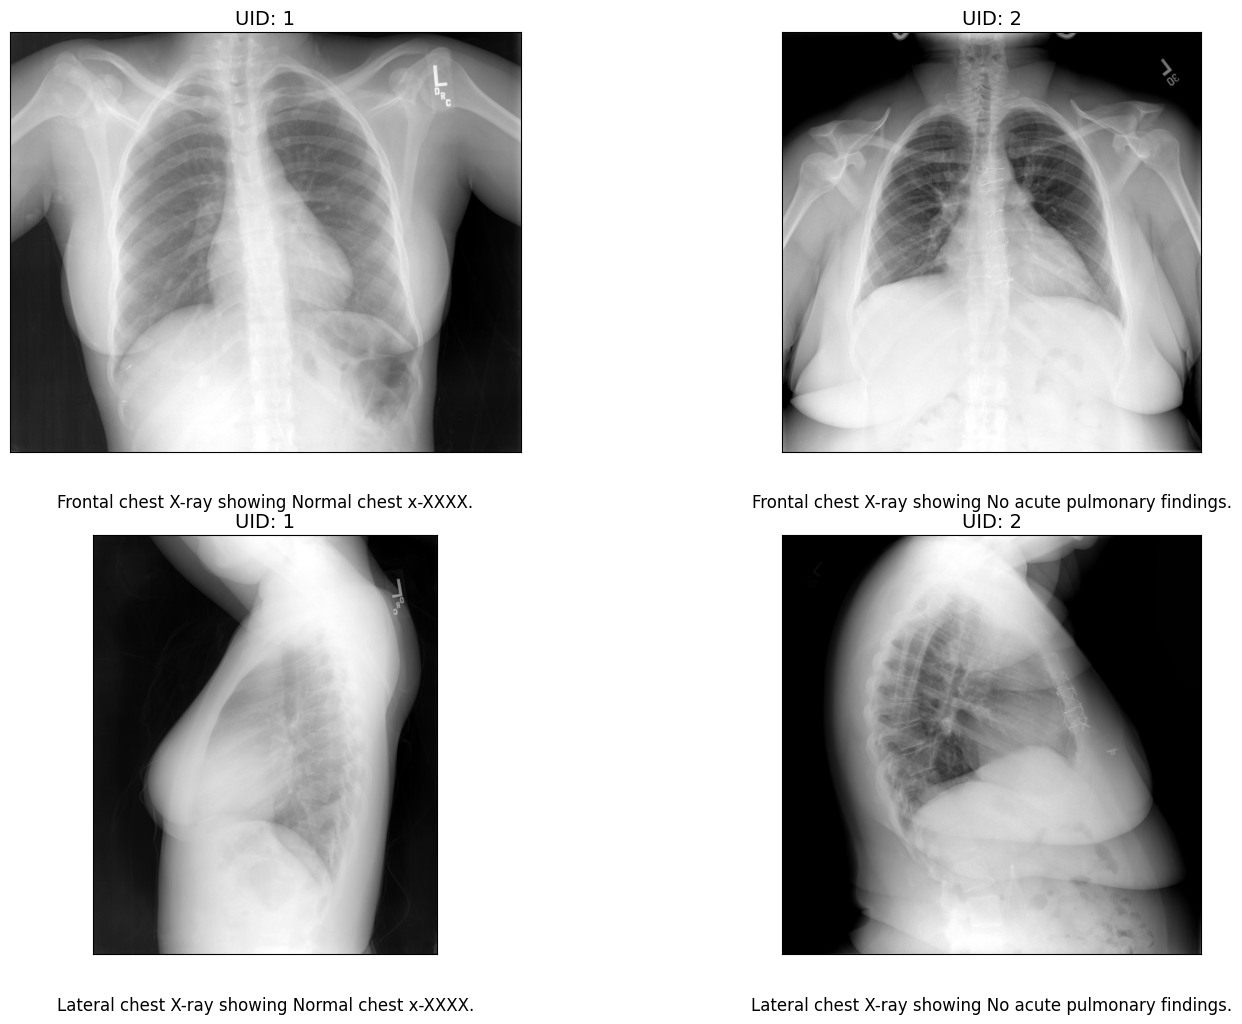

Visualization saved as 'xray_images_with_labels.png'
Displayed 4 images with their corresponding labels


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
import textwrap

# Load the labeled dataframe
labeled_df = pd.read_csv('indiana_labeled_data.csv')

# Sample 4 images (try to get 2 frontal and 2 lateral if possible)
frontal_samples = labeled_df[labeled_df['label'].str.contains('Frontal')].head(2)
lateral_samples = labeled_df[labeled_df['label'].str.contains('Lateral')].head(2)

# Combine samples
samples = pd.concat([frontal_samples, lateral_samples])

# If we don't have enough of either view, just take the first 4 rows
if len(samples) < 4:
    samples = labeled_df.head(4)

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Function to wrap text to fit in the figure
def wrap_text(text, width=60):
    return '\n'.join(textwrap.wrap(text, width))

# Loop through the samples and display images with captions
for i, (_, row) in enumerate(samples.iterrows()):
    if i >= 4:  # Limit to 4 images
        break
        
    try:
        # Get the image path from the filename column
        image_path = row['filename']
        
        # Check if the file exists
        if os.path.exists(image_path):
            # Load and display the image
            img = Image.open(image_path)
            axes[i].imshow(img, cmap='gray')
        else:
            # If the file doesn't exist, create a placeholder
            axes[i].text(0.5, 0.5, f"Image not found:\n{os.path.basename(image_path)}", 
                        ha='center', va='center', fontsize=12)
            # Create a gray background
            axes[i].imshow(np.ones((300, 300)) * 0.8, cmap='gray')
            
        # Set the title with the UID
        axes[i].set_title(f"UID: {row['uid']}", fontsize=14)
        
        # Add the label as caption
        wrapped_caption = wrap_text(row['label'])
        axes[i].text(0.5, -0.1, wrapped_caption, 
                    ha='center', va='top', transform=axes[i].transAxes, 
                    fontsize=12, wrap=True)
        
        # Remove axes ticks
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                    ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout to make room for captions
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Save the figure
plt.savefig('xray_images_with_labels.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

print("Visualization saved as 'xray_images_with_labels.png'")
print(f"Displayed {min(len(samples), 4)} images with their corresponding labels")